# LSTM model

## Architecture

Many-to-many

## DataSet implementation

- Index is ticker based (create dictionary)
- Analysis on padding



### Configuration parameters

In [549]:
TRANSFORMED_DATA_FN = "../data/transformed/data.csv" # Data
TRANSFORMED_META_FN = "../data/transformed/data.json" # Metadata

MAX_SEQ_LENGTH = 4

In [550]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import seaborn as sns

sns.set_style("whitegrid")

### Load data

In [551]:
df_1 = pd.read_csv(TRANSFORMED_DATA_FN)

In [552]:
# Convert datetimes

for col in ('calendardate', 'datekey', 'reportperiod', 'lastupdated'):
    df_1[col] = pd.to_datetime(df_1[col])

In [553]:
df_2 = df_1.sort_values(by=['ticker', 'datekey'])

In [554]:
df_2.head()

,ticker,exchange,siccode,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,...,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,price_shifted,pct_change_shifted,class1
0,A,NYSE,3826.0,ART,2014-03-31,2014-06-04,2014-04-30,2019-08-30,132000000.0,1.102600e+10,...,20.360,7.134000e+09,0.0,130000000.0,0.0,21.423,3.658000e+09,58.07,0.010792,0
1,A,NYSE,3826.0,ART,2014-06-30,2014-09-02,2014-07-31,2019-08-30,53000000.0,1.038000e+10,...,20.641,6.610000e+09,0.0,123000000.0,0.0,19.790,3.255000e+09,41.88,-0.278801,0
2,A,NYSE,3826.0,ART,2014-09-30,2014-12-22,2014-10-31,2019-08-30,-334000000.0,1.083100e+10,...,20.964,7.265000e+09,0.0,142000000.0,0.0,21.817,3.798000e+09,40.63,-0.029847,0
3,A,NYSE,3826.0,ART,2014-12-31,2015-03-10,2015-01-31,2019-08-30,-261000000.0,7.519000e+09,...,18.833,4.608000e+09,0.0,157000000.0,0.0,13.714,2.726000e+09,40.31,-0.007876,0
4,A,NYSE,3826.0,ART,2015-03-31,2015-06-05,2015-04-30,2019-08-30,-270000000.0,7.412000e+09,...,16.647,4.555000e+09,0.0,118000000.0,0.0,13.638,2.690000e+09,35.53,-0.118581,0


In [555]:
# Break down the temporal chains

tickers = df_2['ticker'].values
max_count = MAX_SEQ_LENGTH

prev_ticker = tickers[0]
output_tickers = [prev_ticker+"_0"]
counter = 0
append_index = 0

for ticker in tickers[1:]:
    if ticker == prev_ticker:
        counter +=1        
    else:
        counter = 0
        append_index = 0
    if counter == max_count:
        counter = 0
        append_index +=1
    output_tickers.append(ticker+"_{}".format(append_index))
    prev_ticker = ticker
    
assert len(output_tickers) == len(tickers)
output_tickers[:22]
tickers[:22]

df_2['ticker'] = output_tickers

In [556]:
with open(TRANSFORMED_META_FN, 'r') as fp:
    metadata = json.load(fp)
    
features = metadata['features'].split(",")
target = metadata['target']
#target='pct_change_shifted'

In [557]:
features = [ 'assets', 'assetsavg', 'assetsc',
       'assetsnc', 'assetturnover', 'bvps', 'capex', 'cashneq',
       'cashnequsd', 'cor', 'consolinc', 'currentratio', 'de', 'debt',
       'debtc', 'debtnc', 'debtusd', 'deferredrev', 'depamor', 'deposits',
       'divyield', 'dps', 'ebit', 'ebitda', 'ebitdamargin', 'ebitdausd',
       'ebitusd', 'ebt', 'eps', 'epsdil', 'epsusd', 'equity', 'equityavg',
       'equityusd', 'ev', 'evebit', 'evebitda', 'fcf', 'fcfps', 'fxusd',
       'gp', 'grossmargin', 'intangibles', 'intexp', 'invcap',
       'invcapavg', 'inventory', 'investments', 'investmentsc',
       'investmentsnc', 'liabilities', 'liabilitiesc', 'liabilitiesnc',
       'marketcap', 'ncf', 'ncfbus', 'ncfcommon', 'ncfdebt', 'ncfdiv',
       'ncff', 'ncfi', 'ncfinv', 'ncfo', 'ncfx', 'netinc', 'netinccmn',
       'netinccmnusd', 'netincdis', 'netincnci', 'netmargin', 'opex',
       'opinc', 'payables', 'payoutratio', 'pb', 'pe', 'pe1', 'ppnenet',
       'prefdivis', 'price', 'ps', 'ps1', 'receivables', 'retearn',
       'revenue', 'revenueusd', 'rnd', 'roa', 'roe', 'roic', 'ros',
       'sbcomp', 'sgna', 'sharefactor', 'sharesbas', 'shareswa',
       'shareswadil', 'sps', 'tangibles', 'taxassets', 'taxexp',
       'taxliabilities', 'tbvps', 'workingcapital']

In [558]:
seq_lengths = df_2.groupby('ticker').count()['datekey'].values


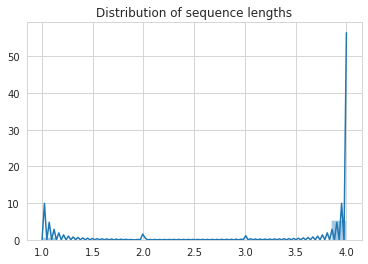

In [559]:
sns.distplot(seq_lengths, bins = 20);
plt.title("Distribution of sequence lengths");

In [560]:
max(seq_lengths)

4

In [561]:
print("Maximum sequence length: ", max(seq_lengths))

Maximum sequence length:  4


In [562]:
def get_padded_features(sorted_df, ticker, features, target, n_pad):
    """ Return padded features and target
    
    Arguments
    ---------
    
    sorted_df : Pandas dataframe
        Dataframe with indicators, sorted by ticker and datekey        
    ticker : str
        Ticker name
    features : list
        Feature names        
    target : str
        Target name
    pad : int
        Pad length
    
    Returns
    -------
    padded_features : ndarray with shape (n_pad, n_features)
    target : ndarray with shape (n_pad,1)
    
    """
    
    n_features = len(features)
    
    ticker_data = sorted_df.loc[sorted_df['ticker'] == ticker, :]
    
    ticker_features = ticker_data.loc[:, features]
    ticker_target = ticker_data.loc[:, target]
    
    out_features = np.zeros((n_pad, n_features))
    out_target = np.zeros((n_pad, 1))
    
    out_features[0:len(ticker_features)] = ticker_features.values
    out_target[0:len(ticker_features)] = ticker_target.values.reshape(-1,1)
    
    return out_features, out_target, len(ticker_features)

In [563]:
feat_array, target_array, len_ticker = get_padded_features(df_2, ticker='GEN', features = features, target = target, n_pad = MAX_SEQ_LENGTH)

In [564]:
feat_array.shape, target_array.shape

((4, 104), (4, 1))

### Prepare data

In [565]:
from torch.utils.data import Dataset, DataLoader

In [566]:
# Create unique ticker list and shuffle

all_tickers = df_2['ticker'].unique()
np.random.shuffle(all_tickers)

In [567]:
len(df_2['ticker'].unique())

24478

In [568]:
class TickersIndicatorsDataset(Dataset):
    """
    Tickers Indicators Dataset
    
    """
    def __init__(self, indicators_df, feature_names, target_name, n_pad):
        
        self.df = indicators_df.sort_values(by=['ticker', 'datekey'])
        self.target = target_name
        self.features = feature_names
        self.ticker_list = self.df['ticker'].unique()
        self.n_pad = n_pad
        
    def __len__(self):
        return len(self.ticker_list)
    
    def __getitem__(self, idx):
        
        ticker = self.ticker_list[idx]
        X, y, len_ticker = get_padded_features(self.df, ticker=ticker, features = self.features, target = self.target, n_pad = self.n_pad)
        
        return torch.from_numpy(X).float(),  torch.tensor(y, dtype=torch.float32), len_ticker

In [569]:
td = TickersIndicatorsDataset(df_2, features, target, MAX_SEQ_LENGTH )

In [570]:
len(td)

24478

### Pre-processing

Scaling and imputation

In [571]:

from sklearn import preprocessing
from sklearn.preprocessing import Imputer

In [572]:
test_ratio = 0.5

test_idx = int(len(all_tickers)*test_ratio)
test_idx = 3000

In [573]:
train_tickers = all_tickers[:test_idx]
test_tickers = all_tickers[test_idx:test_idx+1000]

In [574]:
df_train_all = df_2[df_2['ticker'].isin(train_tickers)]
df_test_all = df_2[df_2['ticker'].isin(test_tickers)]

df_train = df_train_all[features]
df_test = df_test_all[features]

In [575]:
# Imputation

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(df_train)

df_train_imp = pd.DataFrame(imputer.transform(df_train))
df_train_imp.columns = df_train.columns
df_train_imp.index = df_train.index

df_test_imp = pd.DataFrame(imputer.transform(df_test))
df_test_imp.columns = df_test.columns
df_test_imp.index = df_test.index

In [576]:
imputer

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [577]:
# Scaler

scaler = preprocessing.StandardScaler().fit(df_train_imp)

cols, idx = df_train_imp.columns, df_train_imp.index
df_train_imp = pd.DataFrame(scaler.transform(df_train_imp))
df_train_imp.columns = cols
df_train_imp.index = idx

cols, idx = df_test_imp.columns, df_test_imp.index
df_test_imp = pd.DataFrame(scaler.transform(df_test_imp))
df_test_imp.columns = cols
df_test_imp.index = idx

In [578]:
meta_cols = ['ticker', 'datekey',target]

df_train_imp[meta_cols] = df_train_all[meta_cols]
df_test_imp[meta_cols] = df_test_all[meta_cols]

In [579]:
df_train_imp.describe()

,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cashnequsd,cor,...,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,class1
count,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,...,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,1.037900e+04,10379.000000
mean,3.704342e-17,-4.487918e-17,2.847694e-17,-4.616614e-17,2.855516e-17,-2.413320e-17,4.907167e-19,-3.113811e-17,4.638008e-17,-2.762073e-16,...,-3.143127e-17,6.814410e-17,-7.806339e-17,3.884484e-17,-1.072122e-15,-2.436475e-16,1.801973e-16,-4.920538e-19,6.140309e-18,0.066962
std,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,...,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,0.249968
min,-2.873316e-02,-2.963058e-02,-4.567940e-02,-4.945099e-02,-9.828473e-01,-6.149192e+01,-4.229981e+01,-2.416769e-02,-8.874794e-02,-8.798554e-02,...,-4.819632e-02,-2.976965e-01,-4.493900e-02,-2.825114e-02,-3.649033e-02,-2.514880e+00,-4.637820e-02,-2.985976e-02,-2.326742e+01,0.000000
25%,-2.867520e-02,-2.956815e-02,-4.471458e-02,-4.906079e-02,-6.676532e-01,-1.459028e-02,4.569075e-02,-2.414420e-02,-8.756637e-02,-3.911899e-02,...,-4.564658e-02,-2.456680e-01,-4.098710e-02,-2.820352e-02,-3.649033e-02,-4.783732e-02,-4.637820e-02,-2.893905e-02,-3.026035e-02,0.000000
50%,-2.845611e-02,-2.932642e-02,-4.130447e-02,-4.532764e-02,-1.795006e-01,-1.289765e-02,5.265509e-02,-2.407832e-02,-8.426786e-02,-3.824014e-02,...,-4.217301e-02,-1.484399e-01,-3.776324e-02,-2.803724e-02,-3.649033e-02,-4.722959e-02,-4.637326e-02,-2.735253e-02,-2.210956e-02,0.000000
75%,-2.768093e-02,-2.838936e-02,0.000000e+00,7.548665e-18,2.972732e-01,-1.042326e-02,5.366061e-02,-2.385848e-02,-7.336409e-02,-3.317922e-02,...,-3.337822e-02,0.000000e+00,-2.923323e-02,-2.740079e-02,-3.500986e-02,-4.144182e-02,-4.406342e-02,-2.343954e-02,-5.353383e-18,0.000000
max,4.877513e+01,4.844170e+01,5.108481e+01,4.903622e+01,2.047539e+01,5.691689e+01,1.178834e-01,5.764635e+01,2.630629e+01,4.871781e+01,...,4.941509e+01,2.452747e+01,5.860524e+01,4.878340e+01,6.226509e+01,5.010944e+01,4.726189e+01,6.549633e+01,5.056223e+01,1.000000


## LSTM Model

In [580]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [581]:
class Model(nn.Module):
    
    def __init__(self, feature_size, n_activation = 15):
        super(Model, self).__init__()
        
        self.n_activation = n_activation
        
        # LSTM parameters - input feature size X, number of units in hidden layer.
        
        self.lstm = nn.LSTM(feature_size, n_activation, batch_first=True)
        self.linear2 = nn.Linear(n_activation, 5)
        self.out = nn.Linear(5, 1)
        self.out2 = nn.Linear(n_activation, 1)
    
    def forward(self, x, lenx):
        
        # x has dimension of [batch_size, sequence size]       
        
        # Here h_lstm contains hidden activations from all sequences, dimension: [batch_size, seq_size, n_activation]
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x, batch_first=True, lengths=lenx, enforce_sorted=False)
        
        h_lstm, (h_n, c_n) = self.lstm(x_packed)
        #layer2 = torch.relu(self.linear2(h_lstm))
        #out = self.out2(h_lstm)
        padded_output, output_lens = torch.nn.utils.rnn.pad_packed_sequence(h_lstm, batch_first=True, total_length=MAX_SEQ_LENGTH)
#         layer2 = torch.relu(self.linear2(padded_output))
        out = torch.sigmoid(self.out2(padded_output))
        #out = self.out2(padded_output)
        
        return out

In [582]:
df_train_imp.shape[0]

10379

In [583]:
model = Model(feature_size=df_train.shape[1]).cpu()

In [584]:
learning_rate = 0.001
weight_decay=0.0001
batch_size = 150
n_epoch = 100

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [585]:
x_train = TickersIndicatorsDataset(df_train_imp, features, target, MAX_SEQ_LENGTH )
x_test = TickersIndicatorsDataset(df_test_imp, features, target, MAX_SEQ_LENGTH )

In [586]:
train_loader = DataLoader(x_train, batch_size=batch_size)

In [587]:
test_loader = DataLoader(x_test, batch_size=len(x_test))

In [588]:
# ### DEBUG test

# sample_data, sample_target, lenx = next(iter(train_loader))

# sample_data.shape, sample_target.shape

# # Feed sample data
# out = model(sample_data.float(), lenx)

# out.shape

# sample_data.shape

# sample_target.shape

# out.view(batch_size,-1).shape

# sample_target.view(-1, 1).shape

# loss = loss_function(out, sample_target)
# print(loss)


In [589]:
from sklearn.metrics import roc_auc_score

In [590]:
def calc_auc(model, dataloader):
    model.eval()
    roc_list = []
    for data_i, target_i, len_i in dataloader:
        y_pred = model(data_i, len_i).detach().squeeze().reshape(-1,1).numpy()
        y_true = target_i.detach().squeeze().reshape(-1,1).numpy()
        roc_list.append(roc_auc_score(y_true, y_pred))
    return np.average(roc_list)


In [591]:
def calc_loss(output_padded, y):
    batch_ce_loss = 0.0
    for i in range(output_padded.size(0)):
      ce_loss = F.binary_cross_entropy(output_padded[i], y[i], reduction="sum")
      batch_ce_loss += ce_loss
    return batch_ce_loss

In [592]:
train_loss, valid_loss = [], []
for i, epoch in enumerate(range(n_epoch)):

    model.train()
    for data_i, target_i, len_i in train_loader:
        
        optimizer.zero_grad()
        
        output = model(data_i, len_i)
        #loss = loss_function(output, target_i)  
        loss = calc_loss(output, target_i) 
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    auc_train = calc_auc(model, train_loader)


    
    model.eval()
    for data_i, target_i, len_i in test_loader:
        output = model(data_i, len_i)
        #loss2 = loss_function(output, target_i) 
        loss2 = calc_loss(output, target_i) 
        valid_loss.append(loss2.item())
    
    auc_test = calc_auc(model, test_loader)

    print("Epoch: {}, Train loss: {}, Validation loss: {}, AUC train: {}, AUC test: {}".format(i,train_loss[-1], valid_loss[-1], auc_train, auc_test))

Epoch: 0, Train loss: 334.0384826660156, Validation loss: 2193.792724609375, AUC train: 0.4354189182375485, AUC test: 0.42009863048121626
Epoch: 1, Train loss: 307.2469482421875, Validation loss: 1998.0743408203125, AUC train: 0.40126284220836617, AUC test: 0.38355635130041466
Epoch: 2, Train loss: 273.3414611816406, Validation loss: 1753.94677734375, AUC train: 0.3938495781655715, AUC test: 0.37836600075386356
Epoch: 3, Train loss: 242.16989135742188, Validation loss: 1535.88525390625, AUC train: 0.3966321938253505, AUC test: 0.3825587385349919
Epoch: 4, Train loss: 222.68255615234375, Validation loss: 1403.1090087890625, AUC train: 0.40146872613789364, AUC test: 0.39003580851865816
Epoch: 5, Train loss: 211.9206085205078, Validation loss: 1330.675048828125, AUC train: 0.40724963529313757, AUC test: 0.39773715290865685
Epoch: 6, Train loss: 205.2423553466797, Validation loss: 1285.4473876953125, AUC train: 0.41379517181491654, AUC test: 0.40477698203291873
Epoch: 7, Train loss: 200.30

KeyboardInterrupt: 

In [593]:
target_i[0]

tensor([[0.],
        [0.],
        [0.],
        [0.]])

In [594]:
output[0]

tensor([[0.0454],
        [0.0474],
        [0.0672],
        [0.0681]], grad_fn=<SelectBackward>)

In [595]:
len(x_test)

1000

In [596]:
from sklearn.metrics import roc_auc_score

In [597]:
test_loader2 = DataLoader(x_test, batch_size=len(x_test))

In [598]:
model.eval()
for data_i, target_i, len_i in test_loader2:
    out1 = model(data_i, len_i)
    tar1 = target_i
    
    

In [599]:
len_i.shape

torch.Size([1000])

In [600]:
pred = out1.detach().squeeze().numpy()
tar = target_i.detach().squeeze().numpy()

In [601]:
filtered_pred = []
filtered_truth = []
for i, pred_i in enumerate(pred):
    filtered_pred += list(pred_i[:len_i[i]])

for i, tar_i in enumerate(tar):
    filtered_truth += list(tar_i[:len_i[i]])  
filtered_pred = np.array(filtered_pred)
filtered_truth = np.array(filtered_truth)

In [602]:
len(filtered_pred), len(filtered_truth)

(3461, 3461)

In [603]:
roc_auc_score(filtered_truth, filtered_pred)

0.7167421013314584

In [604]:
def extract_col(sorted_df, ticker, col):      
    ticker_data = sorted_df.loc[sorted_df['ticker'] == ticker, :]    
    df_col = ticker_data.loc[:, col]    
    return list(df_col.values)

In [605]:
pct_shifted = []

for ticker in test_tickers:
    pct_shifted = pct_shifted + extract_col(df_test_all, ticker, 'pct_change_shifted')
    
pct_shifted = np.array(pct_shifted)

In [606]:
len(pct_shifted)

3461

In [607]:
market_cap, net_margin = [], []

for ticker in test_tickers:
    market_cap = market_cap + extract_col(df_test_all, ticker, 'marketcap')
    net_margin = net_margin + extract_col(df_test_all, ticker, 'netmargin')

In [608]:
market_cap = np.array(market_cap)
net_margin = np.array(net_margin)

In [616]:
#mask = (market_cap>1000000.0) & (net_margin > -0.5) & (filtered_pred>0.3)
mask = (filtered_pred>0.12)

In [617]:
np.sum(mask)

492

In [618]:
len(filtered_pred[mask])

492

In [619]:
np.average(pct_shifted[mask])

0.0013208837197989994

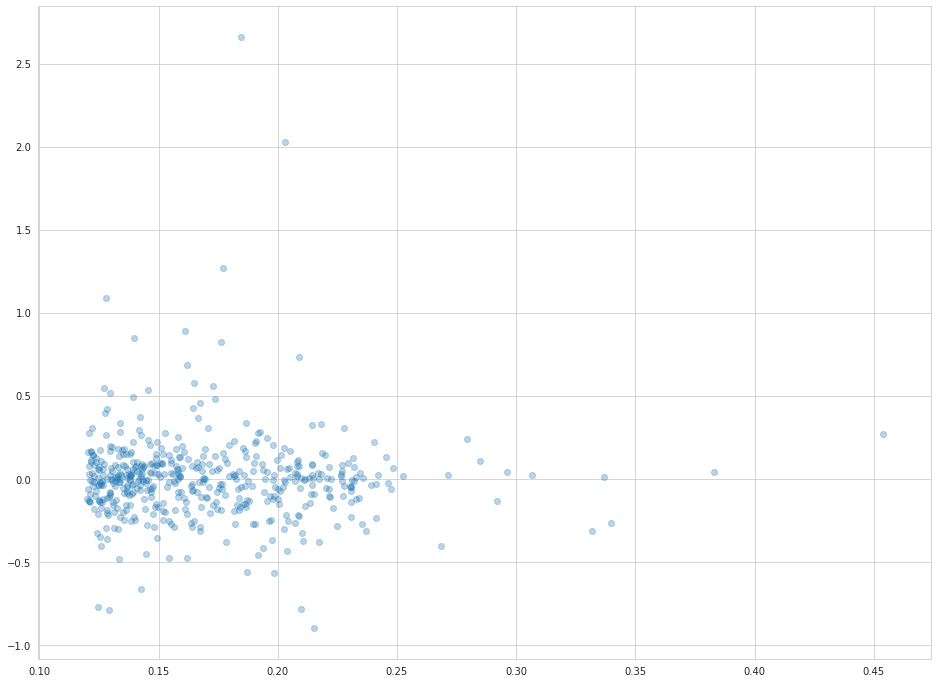

In [620]:
ax, fig = plt.subplots(figsize=(16,12))
plt.scatter(filtered_pred[mask], pct_shifted[mask], alpha=0.3)

In [405]:
out1.shape

torch.Size([1000, 3, 1])

In [406]:
pred = out1.detach().squeeze().reshape(-1,1).numpy()

In [407]:
target_1  = tar1.detach().squeeze().reshape(-1,1).numpy()

In [412]:
pred

array([[0.04939295],
       [0.05987354],
       [0.06831986],
       ...,
       [0.06683617],
       [0.08545984],
       [0.09818827]], dtype=float32)

In [414]:
target_1

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

(array([739., 546., 463., 286., 260., 183., 141.,  95.,  75.,  33.,  13.,
          4.,   1.,   1.,   2.,   4., 150.,   3.,   0.,   1.]),
 array([0.00235533, 0.02382779, 0.04530025, 0.06677271, 0.08824517,
        0.10971763, 0.13119009, 0.15266255, 0.17413501, 0.19560747,
        0.21707994, 0.23855239, 0.26002485, 0.2814973 , 0.30296978,
        0.32444224, 0.3459147 , 0.36738715, 0.38885963, 0.41033208,
        0.43180454], dtype=float32),
 <a list of 20 Patch objects>)

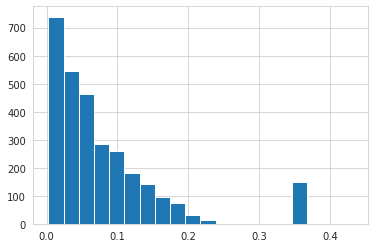

In [418]:
plt.hist(pred, bins = 20)

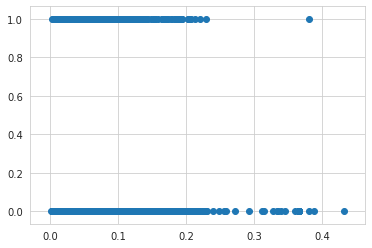

In [420]:
plt.scatter(pred, target_1, )

In [431]:
len(pct_shifted)

2860

In [433]:
len(target_1)

3000

In [428]:
extract_col(df_test_all, 'TGNA_2', 'pct_change_shifted')

[-0.08875739644970404, -0.07751623376623372, -0.05499340079190496]

In [408]:
roc_auc_score(target_1, pred)

0.6338372745686605

In [411]:
i=15
out1[i], tar1[i]

(tensor([[0.0819],
         [0.0373],
         [0.0282]], grad_fn=<SelectBackward>), tensor([[0.],
         [0.],
         [0.]]))

In [ ]:
tar1[5]

In [ ]:
out1.squeeze().detach().numpy()

In [ ]:
tar1.squeeze().numpy()

In [ ]:
tar1.shape

In [ ]:
out1.squeeze().detach().numpy()[99]

In [ ]:
data_i.shape